In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import multiprocessing
# utility functions
import json
import os
from ipynb.fs.full.utilities import BERTModel, download_extract, Vocab, load_data_snli, try_all_gpus, TokenEmbedding, train_and_evaluate, get_dataloader_workers, SNLIBERTDataset, read_snli, BERTClassifier, display_results, unit_testing, compare_results

In [2]:
# global variables
devices = try_all_gpus()

 ---> will run on mps gpu(s) count 1


#### Natural Language Inference with `Decomposable attention model with MLPs(Multi Layer Perceptrons) and GloVe embeddings`
![Solution Overview](images/NaturalLanguageInference.GloVe.png)
###### The solution will feed pretrained [GloVe](GLOVE.md) embeddings to [MLP](MLP.md) and [Attention](ATTENTION.md)

In [3]:
def mlp(num_inputs, num_hiddens, flatten):
    """Inputs are separately taken rather than takes a pair of them together.
       This decomposition trick leads to only m+n applications (linear complexity) 
       rather than m*n applications (quadratic complexity).
    """
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [4]:
class Attend(nn.Module):
    """Compute the soft alignment of hypotheses (beta) withinput premises A and 
       soft alignment of premises (alpha) with input hypotheses B.
    """
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)
    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [5]:
class Compare(nn.Module):
    """Compare between token 𝑖 in the premise and all the hypothesis tokens that are softly aligned with token 𝑖 and 
       compare between token 𝑗 in the hypothesis and all the premise tokens that are softly aligned with token 𝑗.
    """
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)
    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [6]:
class Aggregate(nn.Module):
    """With two comparision vectors as input, aggregate that information to infer the logical relationship.
       This involes summing up both vectors and feed the concatenation of both summarization results into 
       function ℎ (an MLP) to obtain the classification result of the logical relationship.
    """
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)
    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [7]:
class DecomposableAttention(nn.Module):
    """Model to jointly train attention, comparing and aggregating steps together."""
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)
    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [8]:
# Reading the dataset
batch_size, num_steps = 256, 50
train_iter, test_iter, glove_vocab, data_dir = load_data_snli(batch_size, num_steps)


 ---> snli data already extracted at ../data/snli_1.0
 ---> read 549367 examples
 ---> read 9824 examples


In [9]:
# create Model
embed_size, num_hiddens = 100, 200
glove_net = DecomposableAttention(glove_vocab, embed_size, num_hiddens)
glove_embedding = TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[glove_vocab.idx_to_token]
glove_net.embedding.weight.data.copy_(embeds)

tensor([[ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        [ 0.9747,  1.2276,  0.4538,  ...,  0.2209,  1.7439, -0.8991],
        ...,
        [-0.0205, -0.4512,  0.6993,  ...,  0.0381,  0.2786,  0.2889],
        [-0.2484, -0.2568,  0.0255,  ...,  0.2161, -0.3413,  0.6266],
        [-0.1438,  0.8681, -0.7219,  ...,  0.0553, -0.4339,  0.3486]])

{'training': {'total_examples': 549367.0, 'passed': 442082.0, 'failed': 107285.0, 'accuracy': 80, 'loss': '0.497'}, 'test': {'total_examples': 9824.0, 'passed': 8098.0, 'failed': 1726.0, 'accuracy': 82, 'loss': '0.176'}}


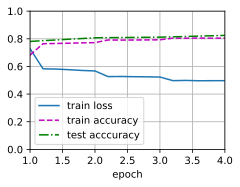

In [10]:
# training and evaluating the model
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(glove_net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
glove_results = train_and_evaluate(glove_net, train_iter, test_iter, loss, trainer, num_epochs, devices)

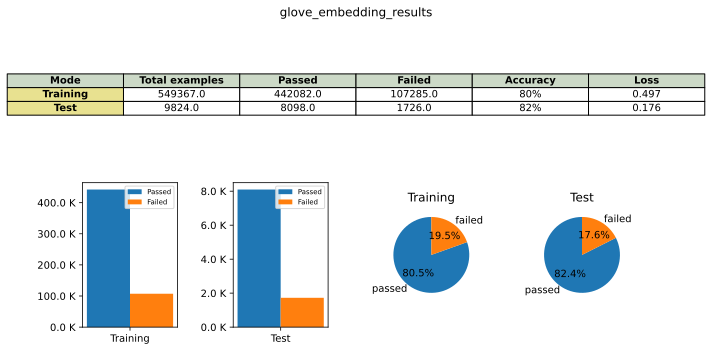

In [11]:
display_results(glove_results, "glove_embedding_results")

#### Natural Language Inference with `MLP(Multi Layer Perceptrons) and BERT(Bidirectional Encoder Representations from Transformers) embeddings`
![Solution Overview](images/NaturalLanguageInference.BERT.png)
###### The solution will feed pretrained [BERT](BERT.md) embeddings to [MLP](MLP.md)

In [12]:
# # bert.small --> for development
bert_type ="bert.small"
num_hiddens = 256
ffn_num_hiddens = 512
num_heads = 4
num_blks = 2

In [13]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len, devices):
    data_dir = download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
    vocab.idx_to_token)}
    bert = BERTModel(len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads,num_blks=num_blks, dropout=dropout, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))
    return bert, vocab

In [14]:
# load pretrained BERT 
bert_small_model, bert_small_vocab = load_pretrained_model(bert_type, num_hiddens=num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, num_blks=num_blks, dropout=0.1, max_len=512, devices=devices)

In [15]:
# Dataset for fine tuning BERT
# Reduce `batch_size` if there is an out of memory error. In the original BERT model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, get_dataloader_workers()
train_set = SNLIBERTDataset(read_snli(data_dir, True), max_len, bert_small_vocab)
test_set = SNLIBERTDataset(read_snli(data_dir, False), max_len, bert_small_vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

 ---> read 549367 examples
 ---> read 9824 examples


In [16]:
# Fine tuning BERT
bert_small_net = BERTClassifier(bert_small_model)

{'training': {'total_examples': 549367.0, 'passed': 445123.0, 'failed': 104244.0, 'accuracy': 81, 'loss': '0.476'}, 'test': {'total_examples': 9824.0, 'passed': 7735.0, 'failed': 2089.0, 'accuracy': 78, 'loss': '0.213'}}


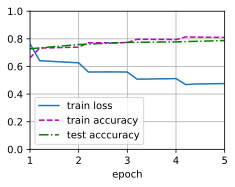

In [17]:
# train and evaluate Model performance
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(bert_small_net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
bert_small_net(next(iter(train_iter))[0])
bert_small_results = train_and_evaluate(bert_small_net, train_iter, test_iter, loss, trainer, num_epochs, devices)

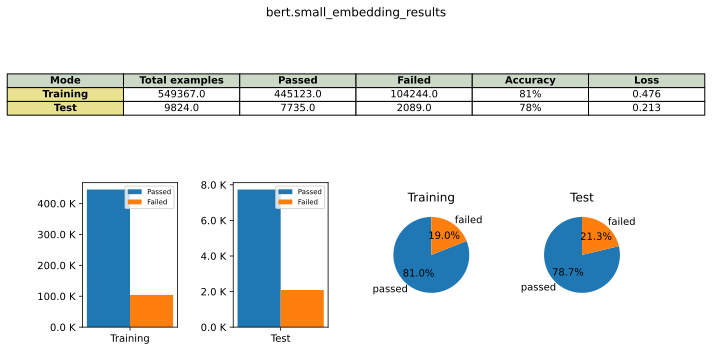

In [18]:
# display results
display_results(bert_small_results, f'{bert_type}_embedding_results')

In [19]:
# # bert.base --> for evaluation and verification *** takes time ***
bert_type ="bert.base"
num_hiddens = 768
ffn_num_hiddens = 3072
num_heads = 12
num_blks = 12

In [20]:
# load pretrained BERT 
bert_base_model, bert_base_vocab = load_pretrained_model(bert_type, num_hiddens=num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, num_blks=num_blks, dropout=0.1, max_len=512, devices=devices)

In [21]:
# Dataset for fine tuning BERT
# Reduce `batch_size` if there is an out of memory error. In the original BERT model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, get_dataloader_workers()
train_set = SNLIBERTDataset(read_snli(data_dir, True), max_len, bert_base_vocab)
test_set = SNLIBERTDataset(read_snli(data_dir, False), max_len, bert_base_vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

 ---> read 549367 examples
 ---> read 9824 examples


In [22]:
# Fine tuning BERT
bert_base_net = BERTClassifier(bert_base_model)

In [23]:
# *** Risky *** , system may be get crashed, but needed to run for bert.base embeddings
# if bert_type == 'bert.base':
#     if devices[0].type == "cuda":
#         torch.cuda.set_per_process_memory_fraction(0.0)
#     elif devices[0].type == "mps":
#         torch.mps.set_per_process_memory_fraction(0.0)

In [24]:
# train and evaluate Model performance
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(bert_base_net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
bert_base_net(next(iter(train_iter))[0])
# got the results running in in Colab.google.com with A100 GPU for 3 hrs.
bert_base_results =  {'training': {'total_examples': 549367.0, 'passed': 508342.0, 'failed': 41025.0, 'accuracy': 92, 'loss': '0.209'}, 'test': {'total_examples': 9824.0, 'passed': 8564.0, 'failed': 1260.0, 'accuracy': 87, 'loss': '0.128'}}
# bert_base_results = train_and_evaluate(bert_base_net, train_iter, test_iter, loss, trainer, num_epochs, devices)

![Bert.Base training](images/bert.base.train.jpeg)

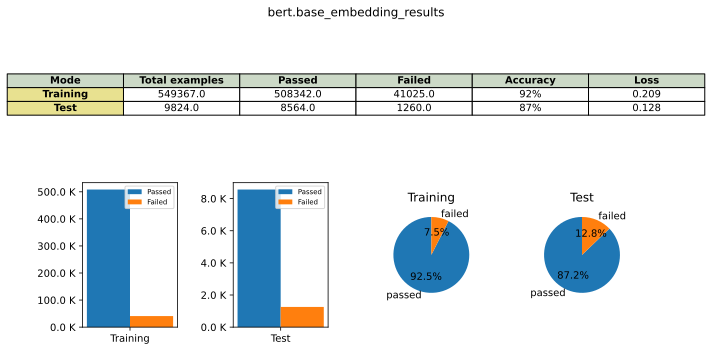

In [25]:
# display results
display_results(bert_base_results, f'{bert_type}_embedding_results')

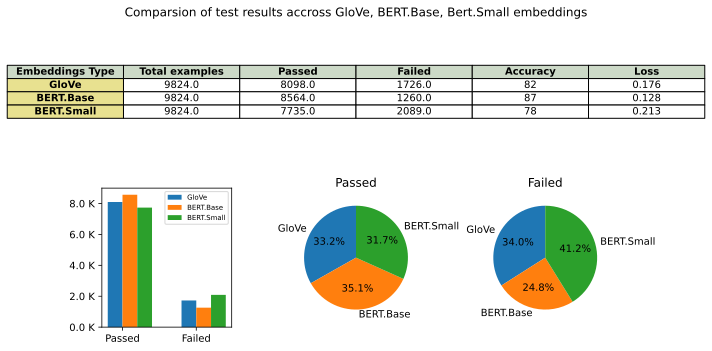

In [26]:
# compare test results across glove embeddings, Bert base and Bert small
compare_results(glove_results, bert_base_results, bert_small_results)

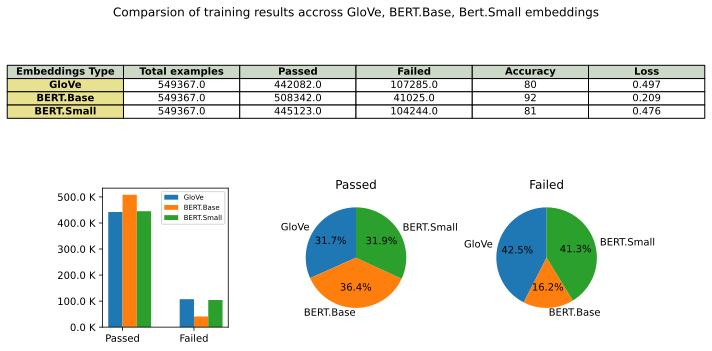

In [27]:
# compare training results across glove embeddings, Bert base and Bert small
compare_results(glove_results, bert_base_results, bert_small_results, "training")

In [28]:
# unit testing
unit_testing(glove_net, glove_vocab, bert_small_net, bert_small_vocab, bert_base_net, bert_base_vocab)

Initial testing results
[
    {
        "Premise:": "A man is running the coding example.",
        "Hypothesis:": "The man is sleeping.",
        "Expected Result": "contradiction",
        "Glove Emeddings Actual Result": "contradiction",
        "Bert.Small Embedings Actual Result": "contradiction",
        "Bert.Base Embedings Actual Result": "entailment"
    },
    {
        "Premise:": "I do need sleep.",
        "Hypothesis:": "I am tired",
        "Expected Result": "entilement",
        "Glove Emeddings Actual Result": "neutral",
        "Bert.Small Embedings Actual Result": "entailment",
        "Bert.Base Embedings Actual Result": "entailment"
    },
    {
        "Premise:": "The musicians are performing for us.",
        "Hypothesis:": "The musicians are famous.",
        "Expected Result": "neutral",
        "Glove Emeddings Actual Result": "neutral",
        "Bert.Small Embedings Actual Result": "neutral",
        "Bert.Base Embedings Actual Result": "entailment"
    }
]